* FTLE para el 01-Oct-2019
* delta0 (separación inicial en deg) 
1/64 y 1/8
* tiempo de integración.
15d y 30d

* backward o forward?

* FSLE Vero: df=10*d0, 

* Lat: 32-38
* Lon: 330-345 (-30, -15)

We then instatiate a `FieldSet` with the velocity field data from GlobCurrent dataset. https://data.marine.copernicus.eu/product/SEALEVEL_GLO_PHY_L4_MY_008_047/description

In [1]:
%matplotlib inline
from parcels import FieldSet, ParticleSet, JITParticle, AdvectionRK4, plotTrajectoriesFile
from datetime import timedelta, datetime
from glob import glob
import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
#from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter#
import matplotlib.ticker as mticker

In [2]:
1./64.

0.015625

In [3]:
# Parameters:

#Particle_AZO_grid100000_notides_Dec_week01_hourly.nc
grid_name = "1-64grid"
nyear = 2019
nmonth = 10
simu_length = 15. # monthly # days

# Defining grid of starting particles:

if grid_name == "1-8grid":
    step = .125 # degrees
elif grid_name == "1-64grid":
    step = 0.015625 # 1./64degrees
else:
    print("Error")
    fszfasgasg
    
lons, lats = np.meshgrid(np.arange(360.-30, 360.-15+step, step), np.arange(32, 38+step, step))
lons.shape[0]*lons.shape[1]

data_path = '../validation/'
fname = 'datos_Laura.nc'

In [4]:
variables = {'U': 'ugos', 'V': 'vgos'}

filenames = {'U': data_path + fname, 'V': data_path + fname}

dimensions = {'U': {'lat': 'latitude', 'lon': 'longitude', 'time': 'time'},
              'V': {'lat': 'latitude', 'lon': 'longitude', 'time': 'time'}}

fieldset = FieldSet.from_netcdf(filenames, variables, dimensions)

#

In [5]:
outdir = '../examples/'

# Define start date:
start_day = 1 #[1, 8, 15, 22]

outname = outdir + "Particle_AZO_fFTLE_" + grid_name + "_" + str(nmonth).zfill(2) + str(start_day).zfill(2) + "_" + str(simu_length)[0:2] + "d"

In [6]:
pset = ParticleSet(fieldset=fieldset, pclass=JITParticle, lon=lons, lat=lats, time=datetime(nyear, nmonth, start_day, 0, 0)) #30))

output_file = pset.ParticleFile(name=outname, outputdt=timedelta(hours=6))

#minutes=6*60
pset.execute(AdvectionRK4, runtime=timedelta(days=simu_length), dt=timedelta(hours=6),
      output_file=output_file) #recovery={ErrorCode.ErrorOutOfBounds: DeleteParticle},

output_file.export()  # export the trajectory data to a netcdf file


INFO: Compiled JITParticleAdvectionRK4 ==> /var/folders/54/mb8qg4_j53d9_q2jnv7n8sjc0000gn/T/parcels-501/f101bd9f00d49175c692b32fbbb8574b_0.so
INFO: Temporary output files are stored in ../examples/out-TZZCBCHE.
INFO: You can use "parcels_convert_npydir_to_netcdf ../examples/out-TZZCBCHE" to convert these to a NetCDF file during the run.
100% (1296000.0 of 1296000.0) |##########| Elapsed Time: 0:01:04 Time:  0:01:04


# Checking the outputs:

In [7]:
ds = xr.open_dataset(outdir + 'Particle_AZO_fFTLE_1-64grid_1001_15d.nc')

In [8]:
ds

<xarray.Dataset>
Dimensions:     (obs: 61, traj: 369985)
Dimensions without coordinates: obs, traj
Data variables:
    trajectory  (traj, obs) float64 ...
    time        (traj, obs) datetime64[ns] ...
    lat         (traj, obs) float32 ...
    lon         (traj, obs) float32 ...
    z           (traj, obs) float32 ...
Attributes:
    feature_type:           trajectory
    Conventions:            CF-1.6/CF-1.7
    ncei_template_version:  NCEI_NetCDF_Trajectory_Template_v2.0
    parcels_version:        2.2.1
    parcels_mesh:           spherical

## Plotting

### All particles at all times:

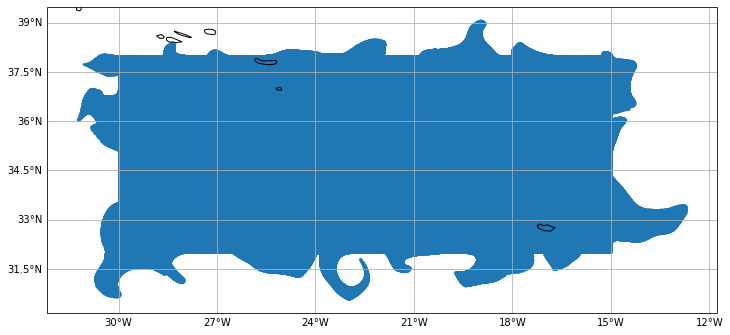

In [22]:
plt.figure(figsize=(12,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
ax1.scatter(ds['lon'], ds['lat'], s=1, transform=ccrs.PlateCarree()) #marker='o'
# ax1.set_xlim([6, 11])
# ax1.set_ylim([54.5, 59])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
#gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER


### All particles at last timestep:

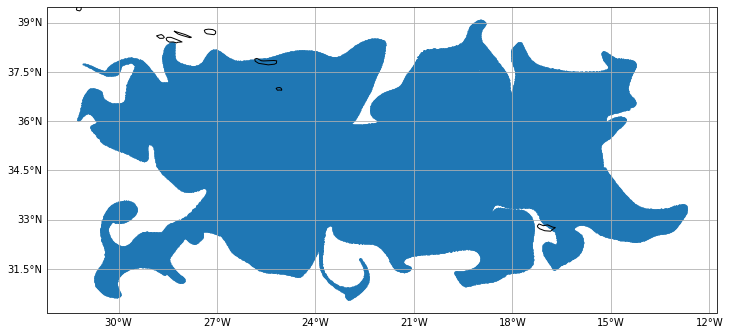

In [21]:
plt.figure(figsize=(12,10)) #(17,5)

ax1 = plt.subplot(111, projection=ccrs.PlateCarree())
ax1.coastlines(resolution='50m')
#ax1.add_feature(cartopy.feature.LAND, facecolor='black')
ax1.scatter(ds['lon'][:,-1], ds['lat'][:,-1], s=1, transform=ccrs.PlateCarree()) #marker='o'
# ax1.set_xlim([6, 11])
# ax1.set_ylim([54.5, 59])
gl = ax1.gridlines(crs=ccrs.PlateCarree(), draw_labels=True)
gl.top_labels = False
gl.right_labels = False
#gl.ylocator = mticker.FixedLocator([0, 5, 10, 15, 20, 25, 30, 35])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
